In [1]:
import pandas as pd
import numpy as np
from prog.model import * 
from prog.tools import *
from tqdm import tqdm
import warnings, pickle, time, os, random
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")


random_state = None
limit_end = 30
model_boundary = 0.5
minute = 5
stop = minute * 60

In [2]:
input_ = {
    "model_id": "20230807120000000",
}
model_id = input_["model_id"]

In [3]:
root = r"C:\Users\tzuli\Documents\python\teco"

# 取得train位置
train_path = os.path.join(root, "data", "train")        
os.makedirs(train_path, exist_ok = True)
data_csv = os.path.join(train_path, "train_data.csv")
output_json = os.path.join(train_path, "output.json")


# 取得model位置
model_path = os.path.join(root, "data", "train", model_id)
os.makedirs(model_path, exist_ok = True)

model_detail = os.path.join(model_path, "model")
os.makedirs(model_detail, exist_ok = True)

In [4]:
df = pd.read_csv(data_csv)
print(df.shape)
df.head(3)

(278, 16)


,日期,工號,序號,平衡轉速,初始_L側角度,初始_L側不平衡量,初始_F側角度,初始_F側不平衡量,平衡_L側角度,平衡_L側配重,平衡_F側角度,平衡_F側配重,最終_L側角度,最終_L側不平衡量,最終_F側角度,最終_F側不平衡量
0,2023-06-01,FC236606T1-2,1,590,12.0,266.0,259.0,181.0,12.0,275.0,259.0,180.0,358.0,58.20,293.0,23.00
1,2023-06-01,FC236606T1-2,2,590,358.0,58.2,293.0,23.0,358.0,60.0,293.0,23.0,307.0,3.50,241.0,3.90
2,2023-06-01,FC236606T1-2,3,590,307.0,3.5,241.0,3.9,307.0,4.0,241.0,4.0,322.0,0.46,214.0,0.36


##### 刪除缺失值

In [5]:
df = df.dropna().reset_index(drop = True)
df.shape

(190, 16)

#### 預期結果

In [6]:
df = generate_feature(df)
df.head(3)

,日期,工號,序號,平衡轉速,初始_L側角度,初始_L側不平衡量,初始_F側角度,初始_F側不平衡量,平衡_L側角度,平衡_L側配重,...,最終_L側角度,最終_L側不平衡量,最終_F側角度,最終_F側不平衡量,預期_F側不平衡量,預期_L側不平衡量,初始_不平衡量_diff,平衡_不平衡量_diff,初始_角度_diff,平衡_角度_diff
0,2023-06-01,FC236606T1-2,1,590,12.0,266.0,259.0,181.0,12.0,275.0,...,358.0,58.20,293.0,23.00,1.0,-9.0,85.0,95.0,113.0,113.0
1,2023-06-01,FC236606T1-2,2,590,358.0,58.2,293.0,23.0,358.0,60.0,...,307.0,3.50,241.0,3.90,0.0,-1.8,35.2,37.0,65.0,65.0
2,2023-06-01,FC236606T1-2,3,590,307.0,3.5,241.0,3.9,307.0,4.0,...,322.0,0.46,214.0,0.36,-0.1,-0.5,0.4,0.0,66.0,66.0


##### Split

In [7]:
target_vol = ["最終_L側不平衡量", "最終_F側不平衡量"]
target_angle = ["最終_L側角度", "最終_F側角度"]
features = df.columns.drop(target_vol + target_angle).to_list()
features = features[3:]
features

['平衡轉速',
 '初始_L側角度',
 '初始_L側不平衡量',
 '初始_F側角度',
 '初始_F側不平衡量',
 '平衡_L側角度',
 '平衡_L側配重',
 '平衡_F側角度',
 '平衡_F側配重',
 '預期_F側不平衡量',
 '預期_L側不平衡量',
 '初始_不平衡量_diff',
 '平衡_不平衡量_diff',
 '初始_角度_diff',
 '平衡_角度_diff']

In [8]:
l_df = df[df[target_vol[0]] <= limit_end].reset_index(drop = True)
f_df = df[df[target_vol[1]] <= limit_end].reset_index(drop = True)

print(f"df: {len(df)}, l_df: {len(l_df)}, f_df: {len(f_df)}")

df: 190, l_df: 175, f_df: 176


### L測預測

In [9]:
side = "L"
total_scores = pd.DataFrame()
total_models = {}
preds = {}
num = 0 # 6, 293, 3
start, end = time.time(), time.time()

l_work_ids = {}
pbar = tqdm(total = stop, ncols = 150)
while (end - start) < stop:
    end = time.time()
    train, test, l_work_ids[num] = split_data(l_df)

    train, test, outlier_boundary = deal_with_outlier(features, train, test)
    train, test, skew_feat, pt = deal_with_skew(features, train, test)
    train, test, scaler = scaling(features, train, test)

    X_train, X_test = train[features], test[features]
    y_train, y_test = train[target_vol[0]], test[target_vol[0]]

    models = modeling(X_train, y_train, random_state = num)

    scores0, pred_trains, pred_tests = calculate_score(models, X_train, X_test, y_train, y_test, scoring = "r2", cv_flag = 1, cv_scoring = "r2", random_state = num)
    scores = scores0.sort_values(("r2", "test"), ascending = False).iloc[[0]]


    if ((scores["r2"] > model_boundary).values.all()):
        preds[num] = {"train": pred_trains, "test": pred_tests}
        total_models[num] = models[scores.index[0]]
        scores["order"] = num
        total_scores = pd.concat([total_scores, scores])
    
    num += 1
    mid = end
    end = time.time()
    pbar.update(round(end - mid, 4))

    # break

pbar.close()

300.78160000000014it [05:00,  1.00s/it]                                                                                                               


In [10]:
total_scores = total_scores.sort_values([('r2',  'test'), ('mape',  'test'), ('r2',  'train'), ('mape',  'train')], ascending = [False, True, False, True])
total_scores_l = total_scores[(total_scores[('r2',  'train')] > total_scores[('r2',  'test')]) & (total_scores[('mape',  'train')] < total_scores[('mape',  'test')])]
if len(total_scores_l) == 0:
    total_scores_l = total_scores.copy()
total_scores_l.head(3)

mse         rmse        mape          r2             order
               train   test train  test train  test train  test    cv      
Neural Network  2.39   4.80  1.55  2.19  0.33  0.80  0.91  0.87  0.88    44
Neural Network  1.91  10.24  1.38  3.20  0.33  1.66  0.92  0.84  0.90    53
Neural Network  2.17   9.86  1.47  3.14  0.39  0.81  0.91  0.82  0.88     9

In [11]:
best_order = total_scores_l["order"].iloc[0]
best_score = total_scores_l.iloc[[0]]
best_score = best_score.drop("order", axis = 1)
best_score.to_csv(os.path.join(model_path, f"{side}_score.csv"))
model = total_models[best_order]
print("L測模型結果")
best_score

L測模型結果


mse       rmse        mape         r2            
               train test train  test train test train  test    cv
Neural Network  2.39  4.8  1.55  2.19  0.33  0.8  0.91  0.87  0.88

In [12]:
test = l_df.query("工號 in @l_work_ids[@best_order]")
train = l_df.query("工號 not in @l_work_ids[@best_order]")
print(f"train: {len(train)}, test: {len(test)}, l_df: {len(l_df)}")

train: 140, test: 35, l_df: 175


In [13]:
print(best_order)
print(f"test_work_ids = {l_work_ids[best_order]}")

44
test_work_ids = ['FC237522', 'FC237401-2', 'FC236361-1', 'FC237605-1', 'FC236302-3', 'FC236361-2', 'FC237402-2', 'FC236627', 'FC237402-2', 'FC236001', 'FC236302-1', 'FC234607-2', 'FC226527']


In [14]:
# 78
test_work_ids = ['FC237522', 'FC236302-1', 'FC236302-3', 'FC237526', 'FC225607-2', 'FC236003-1', 'FC236001', 'FC236362', 'FC236608', 'FC236528', 'FC236003-3', 'FC237401-1', 'FC236531']

In [15]:
l_df1 = l_df.query("工號 in @test_work_ids")
l_df1[["日期", "工號"]].drop_duplicates()

,日期,工號
10,2023-06-07,FC236001
19,2023-06-07,FC236531
30,2023-06-08,FC236528
46,2023-06-10,FC225607-2
70,2023-06-13,FC236003-1
81,2023-06-13,FC236608
89,2023-06-15,FC236003-3
98,2023-06-16,FC236302-1
100,2023-06-16,FC236302-3
102,2023-06-16,FC236362


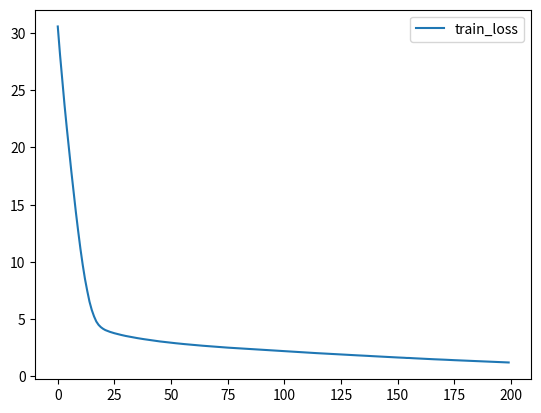

In [16]:
plt.plot(model.loss_curve_)
plt.legend(["train_loss"])

In [17]:
pickle.dump(features, open(os.path.join(model_detail, "feat_order.pkl"), "wb"))
pickle.dump(outlier_boundary, open(os.path.join(model_detail, f"{side}_outlier_boundary.pkl"), "wb"))
pickle.dump(skew_feat, open(os.path.join(model_detail, f"{side}_skew_feat.pkl"), "wb"))
pickle.dump(pt, open(os.path.join(model_detail, f"{side}_power_tf.pkl"), "wb"))
pickle.dump(scaler, open(os.path.join(model_detail, f"{side}_scaler.pkl"), "wb"))
pickle.dump(model, open(os.path.join(model_detail, f"{side}_model.pkl"), "wb"))

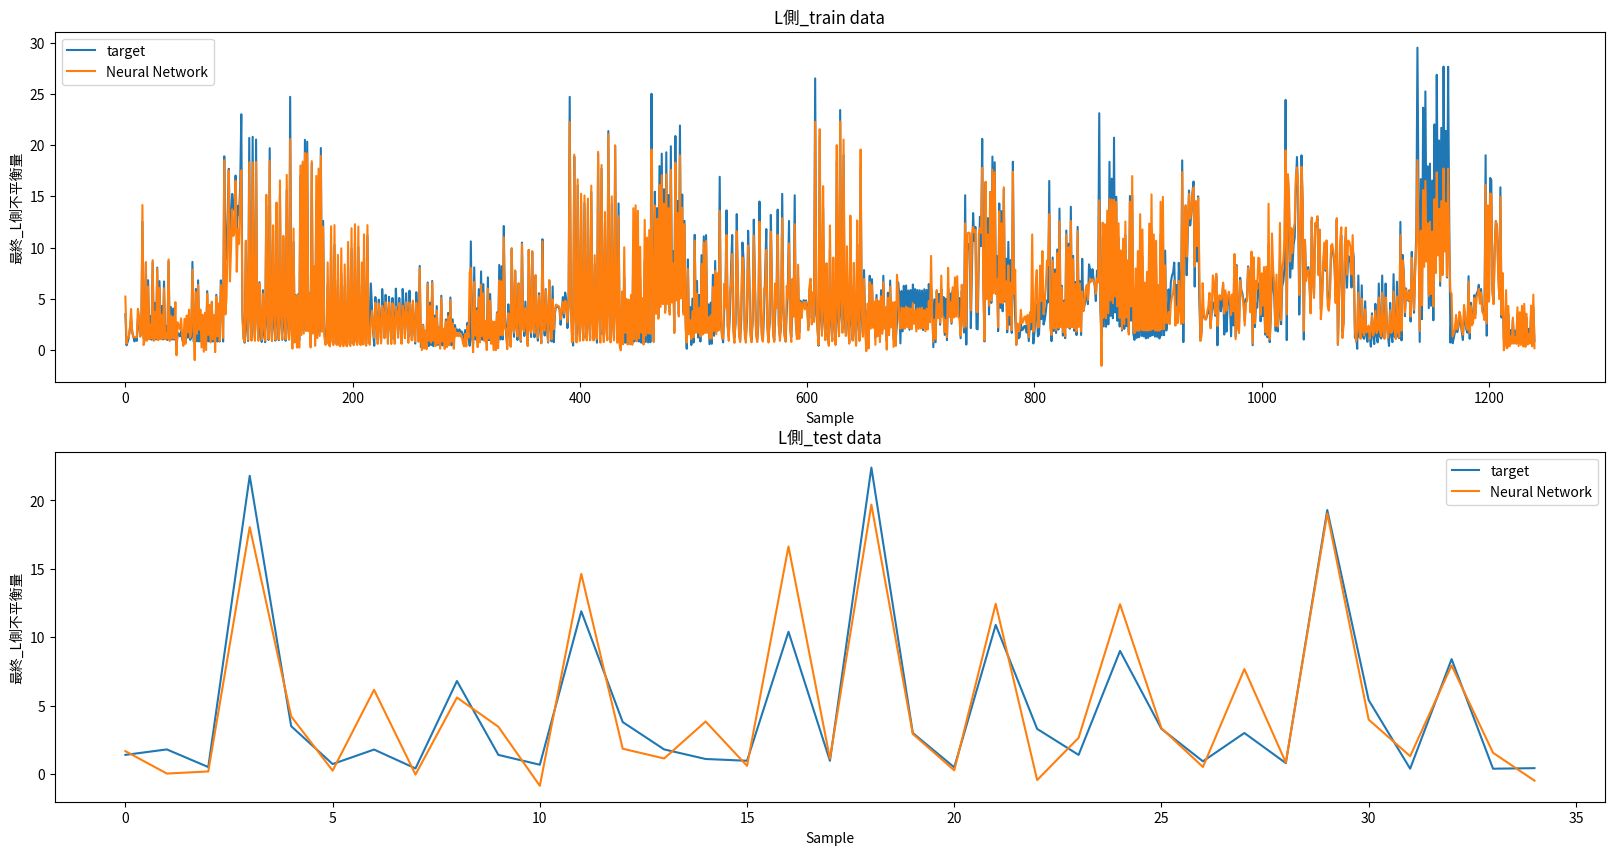

In [18]:
pred_trains, pred_tests = preds[best_order]["train"], preds[best_order]["test"]
pred_plot(pred_trains, pred_tests, best_score, target_vol[0], model_path, side)

### F測預測

In [19]:
side = "F"
total_scores = pd.DataFrame()
total_models = {}
preds = {}
num = 0 # 434, 36, 7
start, end = time.time(), time.time()

f_work_ids = {}
pbar = tqdm(total = stop, ncols = 150)
while (end - start) < stop:
    end = time.time()
    train, test, f_work_ids[num] = split_data(f_df)    

    train, test, outlier_boundary = deal_with_outlier(features, train, test)
    train, test, skew_feat, pt = deal_with_skew(features, train, test)
    train, test, scaler = scaling(features, train, test)

    X_train, X_test = train[features], test[features]
    y_train, y_test = train[target_vol[1]], test[target_vol[1]]

    models = modeling(X_train, y_train, random_state = num)

    scores0, pred_trains, pred_tests = calculate_score(models, X_train, X_test, y_train, y_test, scoring = "r2", cv_flag = 1, cv_scoring = "r2", random_state = num)
    scores = scores0.sort_values(("r2", "test"), ascending = False).iloc[[0]]


    if (scores["r2"] > model_boundary).values.all():
        preds[num] = {"train": pred_trains, "test": pred_tests}
        total_models[num] = models[scores.index[0]]
        scores["order"] = num
        total_scores = pd.concat([total_scores, scores])
    
    num += 1
    mid = end
    end = time.time()
    pbar.update(round(end - mid, 4))
    
    # break

pbar.close()

303.5329it [05:03,  1.00s/it]                                                                                                                         


In [20]:
total_scores = total_scores.sort_values([('r2',  'test'), ('mape',  'test'), ('r2',  'train'), ('mape',  'train')], ascending = [False, True, False, True])
total_scores_f = total_scores[(total_scores[('r2',  'train')] > total_scores[('r2',  'test')]) & (total_scores[('mape',  'train')] < total_scores[('mape',  'test')])]
if len(total_scores_f) == 0:
    total_scores_f = total_scores.copy()
total_scores_f.head(3)

mse         rmse        mape          r2             order
               train   test train  test train  test train  test    cv      
Neural Network  1.41   8.09  1.19  2.84  0.32  1.20  0.94  0.82  0.90     5
Neural Network  1.49  12.82  1.22  3.58  0.30  1.12  0.93  0.74  0.88    48
Neural Network  1.40  12.40  1.18  3.52  0.33  1.14  0.94  0.74  0.89    66

In [21]:
best_order = total_scores_f["order"].iloc[0]
best_score = total_scores_f.iloc[[0]]
best_score = best_score.drop("order", axis = 1)
best_score.to_csv(os.path.join(model_path, f"{side}_score.csv"))
model = total_models[best_order]
print("F測模型結果")
best_score

F測模型結果


mse        rmse        mape         r2           
               train  test train  test train test train  test   cv
Neural Network  1.41  8.09  1.19  2.84  0.32  1.2  0.94  0.82  0.9

In [22]:
test = f_df.query("工號 in @f_work_ids[@best_order]")
train = f_df.query("工號 not in @f_work_ids[@best_order]")
print(f"train: {len(train)}, test: {len(test)}, f_df: {len(f_df)}")

train: 147, test: 29, f_df: 176


In [23]:
print(best_order)
print(f"test_work_ids = {f_work_ids[best_order]}")

5
test_work_ids = ['FC225607-2', 'FC233525-1', 'FC237401-1', 'FC237002-1', 'FC237524', 'FC236002', 'FC236619-1', 'FC236302-2', 'FC236002', 'FC237004', 'FC237401-3', 'FC236617T1-1', 'FC236002']


In [24]:
# 51
test_work_ids = ['FC233525-1', 'FC237002-2', 'FC225607-2', 'FC237302-2', 'FC236003-3', 'FC237401-3', 'FC236002', 'FC236627', 'FC238506', 'FC237402-1', 'FC226530', 'FC237002-1', 'FC234607-2']

In [25]:
f_df1 = f_df.query("工號 in @test_work_ids")
f_df1[["日期", "工號"]].drop_duplicates()

,日期,工號
16,2023-06-07,FC236002
44,2023-06-08,FC234607-2
50,2023-06-10,FC225607-2
72,2023-06-13,FC236627
83,2023-06-13,FC226530
92,2023-06-15,FC236003-3
127,2023-06-30,FC237401-3
136,2023-07-04,FC237302-2
141,2023-07-04,FC238506
149,2023-07-07,FC237402-1


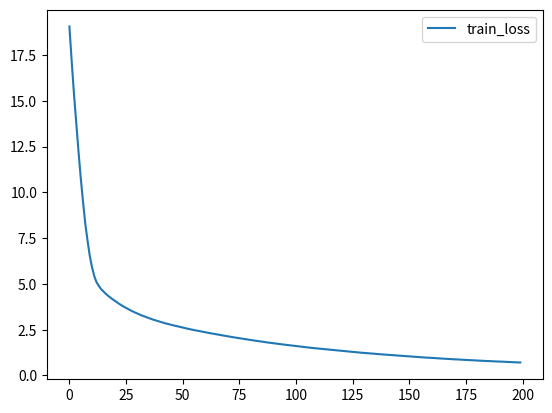

In [26]:
plt.plot(model.loss_curve_)
plt.legend(["train_loss"])

In [27]:
pickle.dump(features, open(os.path.join(model_detail, "feat_order.pkl"), "wb"))
pickle.dump(outlier_boundary, open(os.path.join(model_detail, f"{side}_outlier_boundary.pkl"), "wb"))
pickle.dump(skew_feat, open(os.path.join(model_detail, f"{side}_skew_feat.pkl"), "wb"))
pickle.dump(pt, open(os.path.join(model_detail, f"{side}_power_tf.pkl"), "wb"))
pickle.dump(scaler, open(os.path.join(model_detail, f"{side}_scaler.pkl"), "wb"))
pickle.dump(model, open(os.path.join(model_detail, f"{side}_model.pkl"), "wb"))

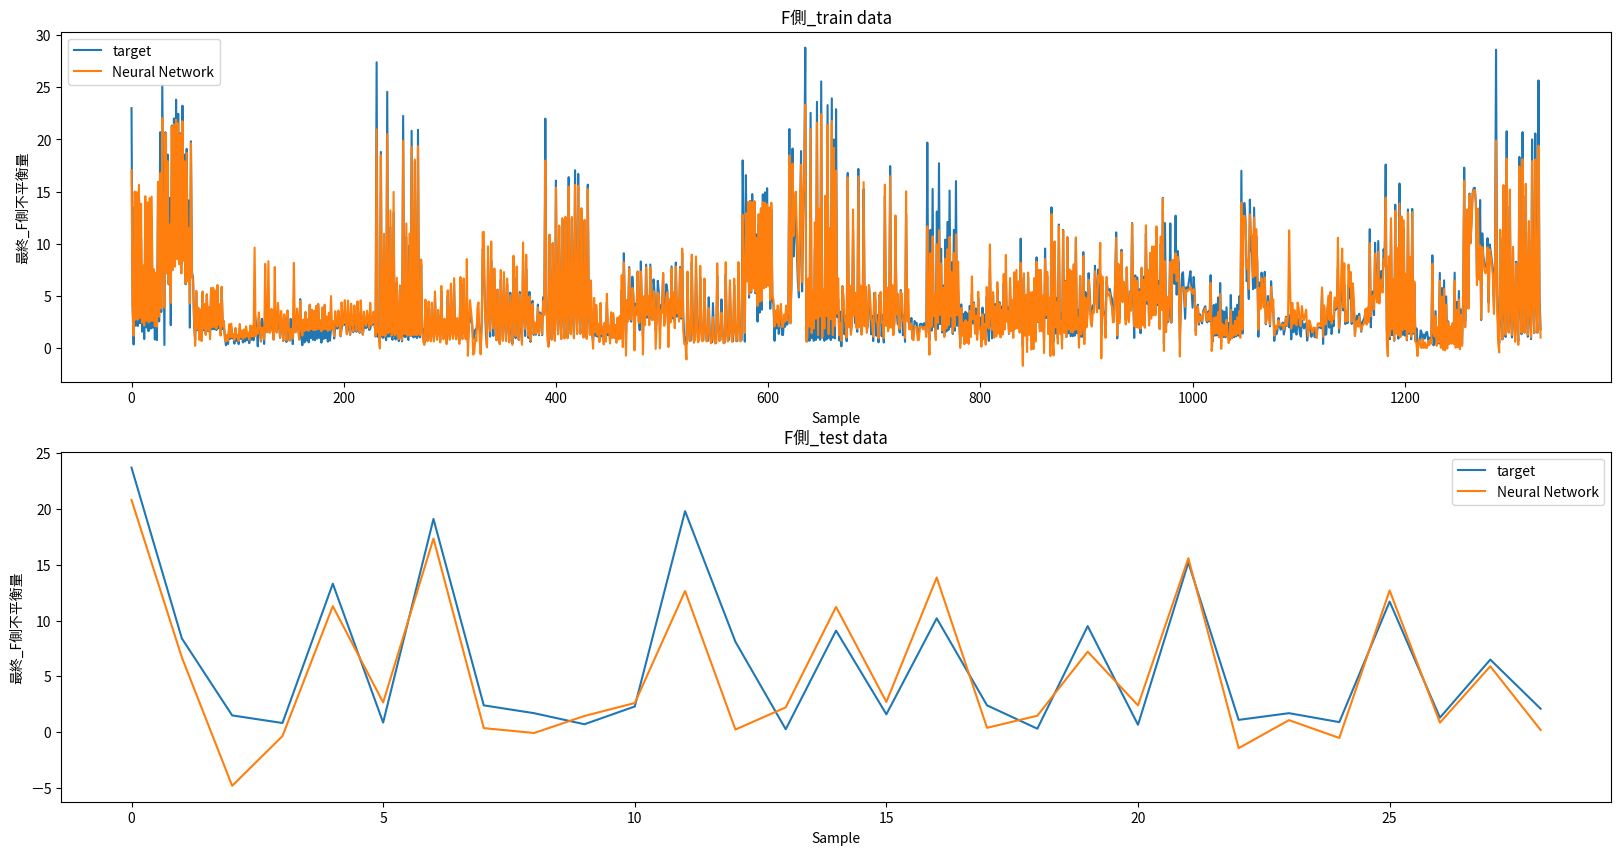

In [28]:
pred_trains, pred_tests = preds[best_order]["train"], preds[best_order]["test"]
pred_plot(pred_trains, pred_tests, best_score, target_vol[1], model_path, side)